In [5]:
import os
import imghdr
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from keras import layers
from keras.models import Sequential

In [6]:
data_dir = "data/rotten_fruits/train/train_"

In [7]:
img_exts = ["jpeg", "jpg", "png"]

In [8]:
for img_class in os.listdir(data_dir):
    for img in os.listdir(os.path.join(data_dir, img_class)):
        img_path = os.path.join(data_dir, img_class, img)
        try:
            cv.imread(img_path)
            _type = imghdr.what(img_path)
            if _type not in img_exts:
                print("img extension not in img_exts {}".format(img_path))
                os.remove(img_path)
        except Exception as e:
            print("issue with image {}".format(img_path))

In [9]:
# data = tf.keras.utils.image_dataset_from_directory(data_dir)

In [10]:
import pathlib

data_dir = pathlib.Path(data_dir)

In [11]:
image_count = len(list(data_dir.glob("*/*.jpg")))
print(image_count)

5640


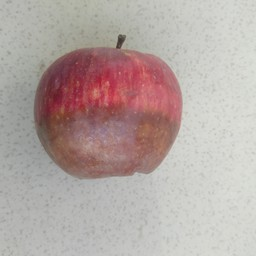

In [20]:
apples = list(data_dir.glob("apple/*"))
PIL.Image.open(str(apples[0]))

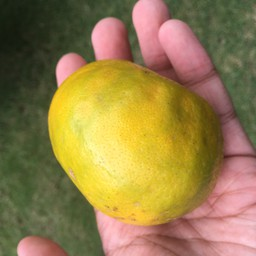

In [9]:
oranges = list(data_dir.glob("orange/*"))
PIL.Image.open(str(oranges[31]))

In [1]:
bananas = list(data_dir.glob("banana/*"))
PIL.Image.open(str(bananas[20]))

NameError: name 'data_dir' is not defined

In [11]:
batch_size = 32
img_height = 180
img_width = 180

In [12]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 5640 files belonging to 3 classes.
Using 4512 files for training.


In [13]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 5640 files belonging to 3 classes.
Using 1128 files for validation.


In [14]:
class_names = train_ds.class_names
print(class_names)

['apple', 'banana', 'orange']


## Visualize the data


2023-04-11 23:48:50.535222: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


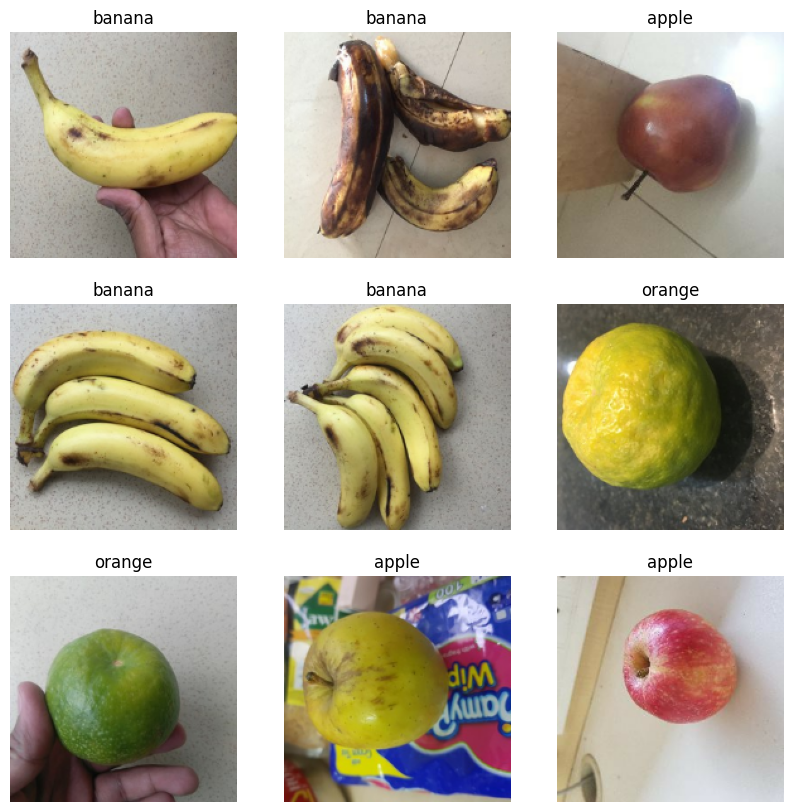

In [15]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Configure the dataset for performance

In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

In [17]:
# normalization_layer = layers.Rescaling(1.0 / 255)

In [18]:
# normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
# image_batch, labels_batch = next(iter(normalized_ds))
# first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
# print(np.min(first_image), np.max(first_image))

## Create the model



In [19]:
num_classes = len(class_names)

# model = Sequential(
#     [
#         layers.Rescaling(1.0 / 255, input_shape=(img_height, img_width, 3)),
#         layers.Conv2D(16, 3, padding="same", activation="relu"),
#         layers.MaxPooling2D(),
#         layers.Conv2D(32, 3, padding="same", activation="relu"),
#         layers.MaxPooling2D(),
#         layers.Conv2D(64, 3, padding="same", activation="relu"),
#         layers.MaxPooling2D(),
#         layers.Flatten(),
#         layers.Dense(128, activation="relu"),
#         layers.Dense(num_classes),
#     ]
# )

In [20]:
# model.compile(
#     optimizer="adam",
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#     metrics=["accuracy"],
# )

In [21]:
# model.summary()

In [22]:
# epochs = 10
# history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

In [23]:
# # print(history.history)
#
# acc = history.history["accuracy"]
# val_acc = history.history["val_accuracy"]
#
# loss = history.history["loss"]
# val_loss = history.history["val_loss"]
#
# epochs_range = range(epochs)
#
# plt.figure(figsize=(8, 8))
# plt.subplot(1, 2, 1)
# plt.plot(epochs_range, acc, label="Training Accuracy")
# plt.plot(epochs_range, val_acc, label="Validation Accuracy")
# plt.legend(loc="lower right")
# plt.title("Training and Validation Accuracy")
#
# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, loss, label="Training Loss")
# plt.plot(epochs_range, val_loss, label="Validation Loss")
# plt.legend(loc="upper right")
# plt.title("Training and Validation Loss")
# plt.show()

## Resolving Overfit

### Data augmentation

In [24]:
# data_augmentation = keras.Sequential(
#     [
#         layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
#         layers.RandomRotation(0.1),
#         layers.RandomZoom(0.1),
#     ]
# )

In [25]:
# plt.figure(figsize=(10, 10))
# for images, _ in train_ds.take(1):
#     for i in range(9):
#         augmented_images = data_augmentation(images)
#         ax = plt.subplot(3, 3, i + 1)
#         plt.imshow(augmented_images[0].numpy().astype("uint8"))
#         plt.axis("off")

### Dropout

In [26]:
model = Sequential(
    [
        # data_augmentation,
        # layers.Rescaling(1.0 / 255),
        layers.Rescaling(1.0 / 255, input_shape=(img_height, img_width, 3)),
        layers.Conv2D(16, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dense(num_classes, name="outputs"),
    ]
)

In [27]:
# model.compile(
#     optimizer="adam",
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#     metrics=["accuracy"],
# )

model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [29]:
epochs = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/20
141/141 [==============================] - 57s 390ms/step - loss: 0.4523 - accuracy: 0.8191 - val_loss: 0.1309 - val_accuracy: 0.9637
Epoch 2/20
141/141 [==============================] - 60s 424ms/step - loss: 0.1205 - accuracy: 0.9619 - val_loss: 0.0922 - val_accuracy: 0.9690
Epoch 3/20
141/141 [==============================] - 61s 430ms/step - loss: 0.0706 - accuracy: 0.9767 - val_loss: 0.0499 - val_accuracy: 0.9867
Epoch 4/20
141/141 [==============================] - 58s 413ms/step - loss: 0.0387 - accuracy: 0.9883 - val_loss: 0.0521 - val_accuracy: 0.9849
Epoch 5/20
141/141 [==============================] - 62s 442ms/step - loss: 0.0250 - accuracy: 0.9927 - val_loss: 0.0377 - val_accuracy: 0.9858
Epoch 6/20
141/141 [==============================] - 57s 401ms/step - loss: 0.0100 - accuracy: 0.9971 - val_loss: 0.0474 - val_accuracy: 0.9814
Epoch 7/20
141/141 [==============================] - 64s 455ms/step - loss: 0.0953 - accuracy: 0.9699 - val_loss: 0.0605 - val_ac

## Visualize Training Results

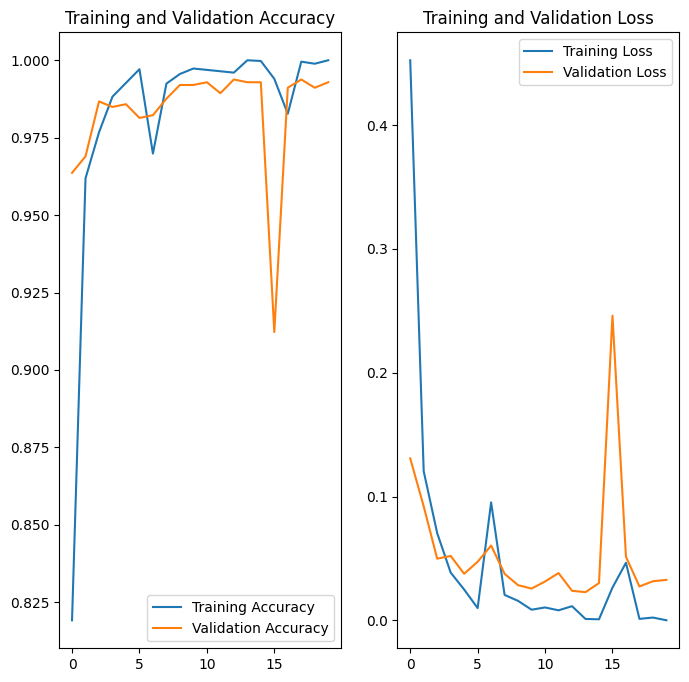

In [30]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

In [31]:
# from tensorflow.keras.metrics import Accuracy, Precision, Recall

# pre = Precision()
# re = Recall()
# acc = Accuracy()

# test = keras.utils.image_dataset_from_directory("rotten_fruits/train/test_/")

# for batch in test.as_numpy_iterator():
    # X, y = batch
    # yhat = model.predict(X)
    # pre.update_state(y, yhat)
    # re.update_state(y, yhat)
    # acc.update_state(y, yhat)

# print(f"Precision: {pre.result().numpy()}")
# print(f"Recall: {re.result().numpy()}")
# print(f"Accuracy: {acc.result().numpy()}")

### Test

In [32]:
def predict_image_from_path(img_path):
    img = tf.keras.utils.load_img(
        img_path, target_size=(img_height, img_width))

    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array, verbose=False)
    score = tf.nn.softmax(predictions[0])

    res = class_names[np.argmax(score)]
    percentage = 100 * np.max(score)
    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(res, percentage)
    )

    return res, percentage

In [33]:
img_path = "data/banana1.jpeg"
predict_image_from_path(img_path)

This image most likely belongs to banana with a 99.99 percent confidence.


('banana', 99.99241828918457)

#### One directory of images (change expected class)

In [34]:
test_dir = "data/test/freshapples"

total_size = len(os.listdir(test_dir))
total_right = 0

expected_class = "apple"

for img in os.listdir(test_dir):
    img_path = os.path.join(test_dir, img)

    res, percentage = predict_image_from_path(img_path)

    if res == expected_class:
        total_right += 1

print(
    f"Result overall: got { total_right }/{ total_size } right, which means { round( total_right * 100 / total_size, 2) }%"
)

This image most likely belongs to apple with a 100.00 percent confidence.
This image most likely belongs to apple with a 100.00 percent confidence.
This image most likely belongs to apple with a 100.00 percent confidence.
This image most likely belongs to apple with a 100.00 percent confidence.
This image most likely belongs to apple with a 100.00 percent confidence.
This image most likely belongs to apple with a 100.00 percent confidence.
This image most likely belongs to apple with a 100.00 percent confidence.
This image most likely belongs to banana with a 99.94 percent confidence.
This image most likely belongs to apple with a 100.00 percent confidence.
This image most likely belongs to apple with a 100.00 percent confidence.
This image most likely belongs to apple with a 100.00 percent confidence.
This image most likely belongs to apple with a 100.00 percent confidence.
This image most likely belongs to apple with a 100.00 percent confidence.
This image most likely belongs to appl

#### Directories with images of three classes

In [35]:
test_dir = "data/rotten_fruits/test/test_/"

apples_right = 0
oranges_right = 0
bananas_right = 0

for img_class in os.listdir(test_dir):
    for img in os.listdir(os.path.join(test_dir, img_class)):
        img_path = os.path.join(test_dir, img_class, img)

        res, percentage = predict_image_from_path(img_path)

        if img_class == "apple" and res == "apple":
            apples_right += 1
        elif img_class == "banana" and res == "banana":
            bananas_right += 1
        elif img_class == "orange" and res == "orange":
            oranges_right += 1
    print()

apples_size = len(os.listdir(os.path.join(test_dir, "apple")))
bananas_size = len(os.listdir(os.path.join(test_dir, "banana")))
oranges_size = len(os.listdir(os.path.join(test_dir, "orange")))
total_size = apples_size + bananas_size + oranges_size
total_right = apples_right + bananas_right + oranges_right

print(
    f"Result apples: got { apples_right }/{ apples_size } right, which means { round(apples_right * 100 / apples_size, 2) }%"
)
print(
    f"Result bananas: got { bananas_right }/{ bananas_size } right, which means { round(bananas_right * 100 / bananas_size, 2) }%"
)
print(
    f"Result oranges: got { oranges_right }/{ oranges_size } right, which means { round(oranges_right * 100 / oranges_size, 2) }%"
)
print()
print(
    f"Result overall: got { total_right }/{ total_size } right, which means { round( total_right * 100 / total_size, 2) }%"
)

This image most likely belongs to apple with a 100.00 percent confidence.
This image most likely belongs to apple with a 100.00 percent confidence.
This image most likely belongs to apple with a 100.00 percent confidence.
This image most likely belongs to apple with a 100.00 percent confidence.
This image most likely belongs to apple with a 100.00 percent confidence.
This image most likely belongs to apple with a 100.00 percent confidence.
This image most likely belongs to apple with a 99.96 percent confidence.
This image most likely belongs to apple with a 100.00 percent confidence.
This image most likely belongs to apple with a 100.00 percent confidence.
This image most likely belongs to apple with a 100.00 percent confidence.
This image most likely belongs to apple with a 100.00 percent confidence.
This image most likely belongs to apple with a 100.00 percent confidence.
This image most likely belongs to apple with a 100.00 percent confidence.
This image most likely belongs to apple

## Save Model


In [36]:
# model.save('models/fruitclassifier.h5')

In [37]:
# new_model = tf.keras.models.load_model('models/fruitclassifier.h5')
# new_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)       

In [38]:
# from tensorflow.keras.metrics import Accuracy, Precision, Recall, SparseCategoricalAccuracy
from tensorflow.keras.metrics import SparseCategoricalAccuracy

# pre = Precision()
# re = Recall()
acc = SparseCategoricalAccuracy()

test = keras.utils.image_dataset_from_directory("data/rotten_fruits/test/test_/", image_size=(img_height, img_width))

for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    # pre.update_state(y, yhat)
    # re.update_state(y, yhat)
    acc.update_state(y, yhat)

# print(f"Precision: {pre.result().numpy()}")
# print(f"Recall: {re.result().numpy()}")
print(f"Accuracy: {acc.result().numpy()}")

Found 360 files belonging to 3 classes.
1/1 [==============================] - 0s 52ms/step
Accuracy: 0.9972222447395325


### Testing with apple photos taken by me

In [51]:
# new_model = tf.keras.models.load_model('models/fruitclassifier.h5')
# new_model.summary()

test_dir = "data/macas_real"

total_size = len(os.listdir(test_dir))
total_right = 0

expected_class = "apple"

for img in os.listdir(test_dir):
    img_path = os.path.join(test_dir, img)

    img = tf.keras.utils.load_img(
        img_path, target_size=(img_height, img_width))

    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array, verbose=False)
    score = tf.nn.softmax(predictions[0])

    res = class_names[np.argmax(score)]
    percentage = 100 * np.max(score)
    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(res, percentage)
    )

    if res == expected_class:
        total_right += 1

print(
    f"Result overall: got { total_right }/{ total_size } right, which means { round( total_right * 100 / total_size, 2) }%"
)


This image most likely belongs to apple with a 100.00 percent confidence.
This image most likely belongs to apple with a 100.00 percent confidence.
This image most likely belongs to apple with a 100.00 percent confidence.
This image most likely belongs to apple with a 100.00 percent confidence.
This image most likely belongs to apple with a 100.00 percent confidence.
This image most likely belongs to apple with a 100.00 percent confidence.
This image most likely belongs to apple with a 100.00 percent confidence.
This image most likely belongs to apple with a 100.00 percent confidence.
This image most likely belongs to apple with a 100.00 percent confidence.
Result overall: got 9/9 right, which means 100.0%
